# STAT 542 – Coding Assignment 3
### YuWei Lai / yuwei6
### UIN: 677679455
2021.10.08

In [1]:
%load_ext rpy2.ipython

----
## Part I: Select optimal span for loess


### Import the dataset

In [2]:
%%R
df = read.csv(file = "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/2021 Fall/[STAT542]Statistical Learning/CodingAssignment 3/Coding3_Data.csv")
dim(df)

[1] 30  2


### Implement the own function for LOO-CV
#### Function: lo.lev(x1, sp)
Compute the diagonal entries of the smoother matrix S and store it in a vector "lev"

- x1: n-by-1 feature vector
- sp: a numerical value for "span"


In [3]:
%%R
lo.lev <- function(x1, sp){
  n = length(x1)
  lev = c()
  for(i in 1:n){
    y = rep(0, n)
    y[i] = 1
    fit = loess(y ~ x1, span=sp, control = loess.control(surface = "direct"))
    yi = predict(fit, x1)
    lev = append(lev, yi[i])
  }
  return(lev)
}

#### Function: onestep_CV(x1, y1, sp)
  #####  1) Fit a loess model y1 ~ x1 with span = sp, and extract the corresponding residual vector
  #####  2) Call lo.lev to obtain the diagonal entries of S
  #####  3) Compute LOO-CV and GCV

In [4]:
%%R
onestep_CV <- function(x1, y1, sp){
    n = length(x1)
  
    # (1-1) fitted a loess model
    fit0 <- loess(y1 ~ x1, span = sp, control = loess.control(surface = "direct"))
    # (1-2) Extract the residual vector
    r = matrix(fit0$residuals)
    
    # (2) Call lo.lev and get the diagonal entries
    lev = lo.lev(x1, sp)
    
    # (3) Compute LOO-CV and GCV
    tr_s = sum(lev) ### get the trace of s --> sum(lev)
    
    ## LOO-CV and GCV
    cv = sum((r)^2 / (1 - lev)^2) / n
    gcv = sum((r)^2 /(1 - tr_s/n)^2) / n
    
    return(list(cv = cv, gcv = gcv))
}

#### Function: myCV(x1, y1, span)
Implement the LOO_CV
- x1: feature vector of length n
- y1: response vector of length n
- span: a sequence of values for "span"

In [5]:
%%R
myCV <- function(x1, y1, span){
  m = length(span)
  cv = rep(0, m)
  gcv = rep(0, m)
  
  for(i in 1:m){
    tmp = onestep_CV(x1, y1, span[i])
    cv[i] = tmp$cv
    gcv[i] = tmp$gcv
  }
  return(list(cv = cv, gcv = gcv))
}

### Test my code

In [6]:
%%R
span1 = seq(from = 0.2, by = 0.05, length = 15)
cv.out = myCV(df$x, df$y, span1)

# Result
myout = data.frame(CV = cv.out$cv, 
                   GCV = cv.out$gcv, 
                   span = span1)
myout

          CV      GCV span
1  12.416167 2.109088 0.20
2   2.241351 1.489063 0.25
3   1.502957 1.190075 0.30
4   1.302611 1.155223 0.35
5   1.223215 1.081272 0.40
6   1.173550 1.046493 0.45
7   1.121463 1.016964 0.50
8   1.166369 1.105829 0.55
9   1.172145 1.112322 0.60
10  1.228412 1.158067 0.65
11  1.273253 1.209565 0.70
12  1.319765 1.266375 0.75
13  1.514219 1.440057 0.80
14  1.792494 1.703384 0.85
15  1.878643 1.782755 0.90


#### ***Results on LOO-CV and GCV: Both achieve the minimal at 0.5***

In [7]:
%%R
myout$span[myout$CV == min(myout$CV)]

[1] 0.5


In [8]:
%%R
myout$span[myout$GCV == min(myout$GCV)]

[1] 0.5


### Plot the fitted curve

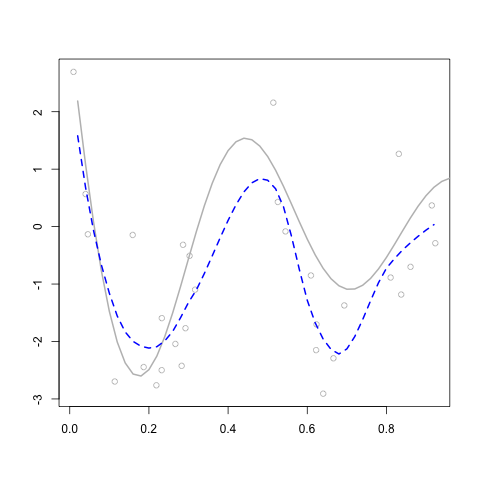

In [9]:
%%R
spangcv.min = 0.5

plot(df$x, df$y, xlab="", ylab="", col="gray");
fx = 1:50/50;
fy = sin(12*(fx+0.2))/(fx+0.2)
lines(fx, fy, col=8, lwd=2);

f = loess(y ~ x, df, span = spangcv.min)
lines(fx, predict(f, data.frame(x = fx), surface = "direct"), 
      lty=2, lwd=2, col="blue")

----
## Part 2: Clustering time series
Data - the Sales Transactions Dataset Weekly dataset from UCI Machine Learning
Repository

### import libraries and the dataset

In [10]:
import pandas as pd

In [11]:
df_trans = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv")

ts = df_trans.iloc[:,1:53]
ts.index = df_trans.iloc[:,0]

ts = ts.apply(lambda x: x - sum(x)/len(x), axis=1)
ts.head()

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
Product_Code,,,,,,,,,,,,,,,,,,,,,
P1,1.365385,2.365385,0.365385,-1.634615,3.365385,2.365385,4.365385,11.365385,-3.634615,4.365385,...,-5.634615,-2.634615,-1.634615,0.365385,2.365385,-6.634615,-2.634615,-3.634615,-4.634615,0.365385
P2,3.019231,2.019231,-0.980769,-1.980769,3.019231,-2.980769,2.019231,-0.980769,-0.980769,-0.980769,...,-1.980769,0.019231,1.019231,-2.980769,-2.980769,0.019231,1.019231,-2.980769,2.019231,-3.980769
P3,-1.692308,2.307692,-0.692308,0.307692,1.307692,-0.692308,-1.692308,4.307692,3.307692,-2.692308,...,-2.692308,5.307692,-3.692308,-3.692308,-1.692308,-0.692308,5.307692,-0.692308,-0.692308,-1.692308
P4,3.730769,-0.269231,4.730769,-3.269231,0.730769,-2.269231,0.730769,4.730769,4.730769,2.730769,...,0.730769,1.730769,-5.269231,-4.269231,-2.269231,-0.269231,5.730769,-0.269231,-1.269231,-0.269231
P5,-0.461538,-3.461538,4.538462,2.538462,-2.461538,-1.461538,0.538462,5.538462,0.538462,0.538462,...,-1.461538,2.538462,-1.461538,3.538462,-2.461538,-2.461538,-3.461538,2.538462,-0.461538,0.538462


### 1. Create the B matrix
B is the matrix obtain by natural cubic spline with df = 10 (with 8 interior knots)

B_t = ((F_t\*F)^-1)\*F_t\*X_t

#### Obtain the F matrix

In [12]:
%%R -i ts
library(splines)

set.seed(9455)

x = c(1:52) # treat each row as response with a feature which is category 1 ~ 52
f_matrix = ns(x, df=9, intercept = FALSE) # df defined by the package is special that actual df is 10, with 8 interior knots

f_matrix = t(t(f_matrix) - colMeans(f_matrix)) # !!! colMeans is a vertical vector
f_matrix = as.matrix(f_matrix)

dim(f_matrix)

[1] 52  9


#### Obtain the B matrix

In [13]:
%%R
b_matrix = t(solve(t(f_matrix) %*% f_matrix) %*% t(f_matrix) %*% t(ts))

dim(b_matrix)

[1] 811   9


### 2. Clustering with the B Matrix

In [14]:
%%R
all_k = 6
kmeans_b = kmeans(b_matrix, 6)
kmeans_b_centers = f_matrix %*% t(kmeans_b$centers)
dim(kmeans_b_centers)

[1] 52  6


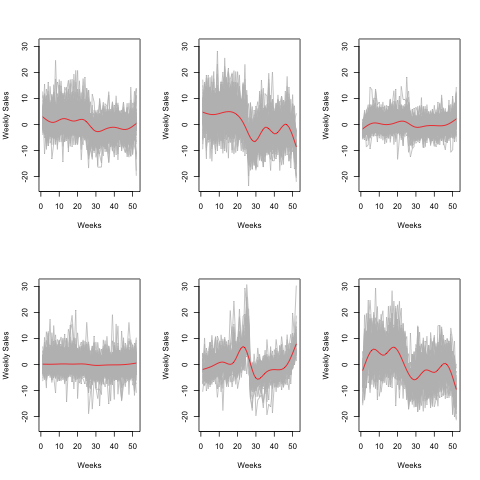

In [15]:
%%R
par(mfrow=c(2,3))
for(k in 1:all_k){
  id=which(kmeans_b$cluster==k)
  plot(NA, xlim = c(1, ncol(ts)), ylim = range(ts), 
       xlab = "Weeks", ylab = "Weekly Sales")
  for(i in 1:length(id))
    lines(1:ncol(ts), ts[id[i],] , col="gray")
  lines(1:ncol(ts), kmeans_b_centers[,k], col="red")
}

### 3. Cluster with the original X matrix

In [16]:
%%R
kmeans_x = kmeans(ts, 6)
kmeans_x_centers = t(kmeans_x$centers)
dim(kmeans_x_centers)

[1] 52  6


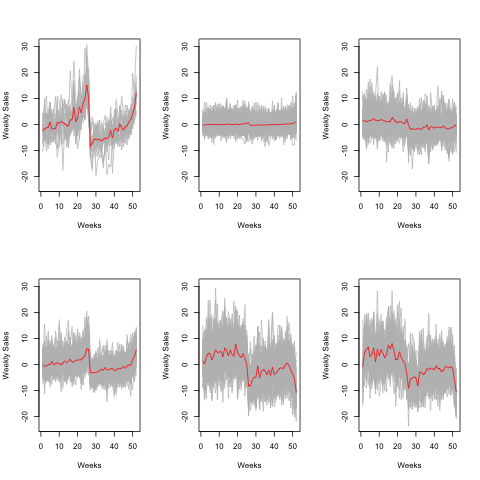

In [17]:
%%R
par(mfrow=c(2,3))
for(k in 1:all_k){
  id=which(kmeans_x$cluster==k)
  plot(NA, xlim = c(1, ncol(ts)), ylim = range(ts), 
       xlab = "Weeks", ylab = "Weekly Sales")
  for(i in 1:length(id))
    lines(1:ncol(ts), ts[id[i],] , col="gray")
  lines(1:ncol(ts), kmeans_x_centers[,k], col="red")
}